## ASTR 597A Homework 3
Eric Bellm

Due Jan 24, 2023

Your name: Tom Wagg
    
Your collaborators: David Wang, Tobin Wainer

In [1]:
# Generic python packages
import numpy as np
import matplotlib.pyplot as plt

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.sphgeom
from lsst.daf.butler import Butler, DatasetType, CollectionType
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument
afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

%config InlineBackend.figure_format = 'retina'

In [2]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

## Exercise 1: Ask the Butler

The 04b (Intermediate Butler Queries) tutorial notebooks may be helpful.

### Exercise 1a

How many DP0.2 tracts have r-band `'deepCoadd'`s?

In [3]:
datasetType = 'deepCoadd'
dataId = {'detector': 175}   # <- still not clear to me why 175? Is this just always filled?
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, where="band = 'r'")

tracts = set()
for ref in datasetRefs:
    tracts.add(ref.dataId["tract"])
        
len(tracts)

157

### Exercise 1b

Find the tract and patch corresponding to (ra, dec) 62.0, -37.0.  If there is more than one r-band `deepCoadd` at that position, make a plot that explains why.

In [4]:
ra, dec = (62.0, -37.0)
pixelization = lsst.sphgeom.HtmPixelization(level)
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra, dec)
    )
)

In [5]:
datasetRefs_at_coords = registry.queryDatasets("deepCoadd", htm20=htm_id, where="band = 'r'")

In [6]:
for deepCoadd in datasetRefs_at_coords:
    print(deepCoadd)

deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 3}, sc=ExposureF] (id=4b0c49ef-36ab-4377-b3a9-62cd8ca60e46)
deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 10}, sc=ExposureF] (id=76cc103b-03ce-4d32-9829-4ba650271878)


In [7]:
deepCoaddData = [butler.get("deepCoadd", dataId={"tract": 3831, "patch": 10, "band": "r"}),
                 butler.get("deepCoadd", dataId={"tract": 3831, "patch": 3, "band": "r"})]

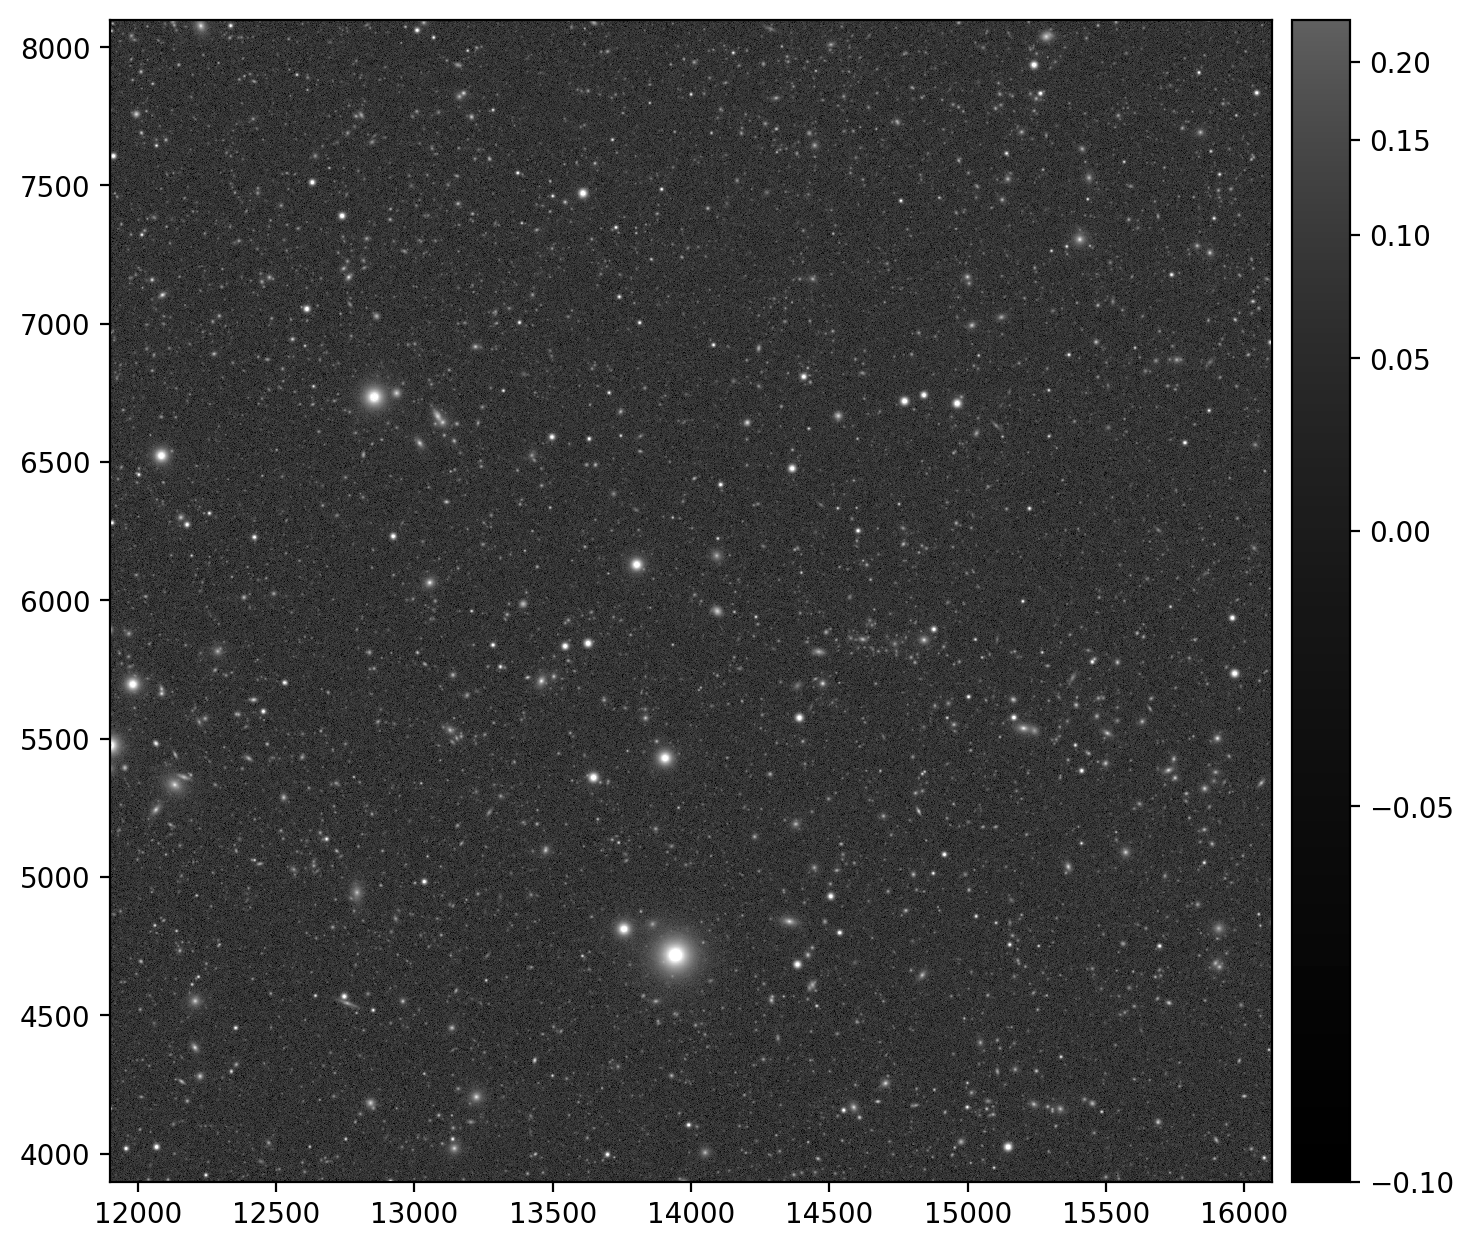

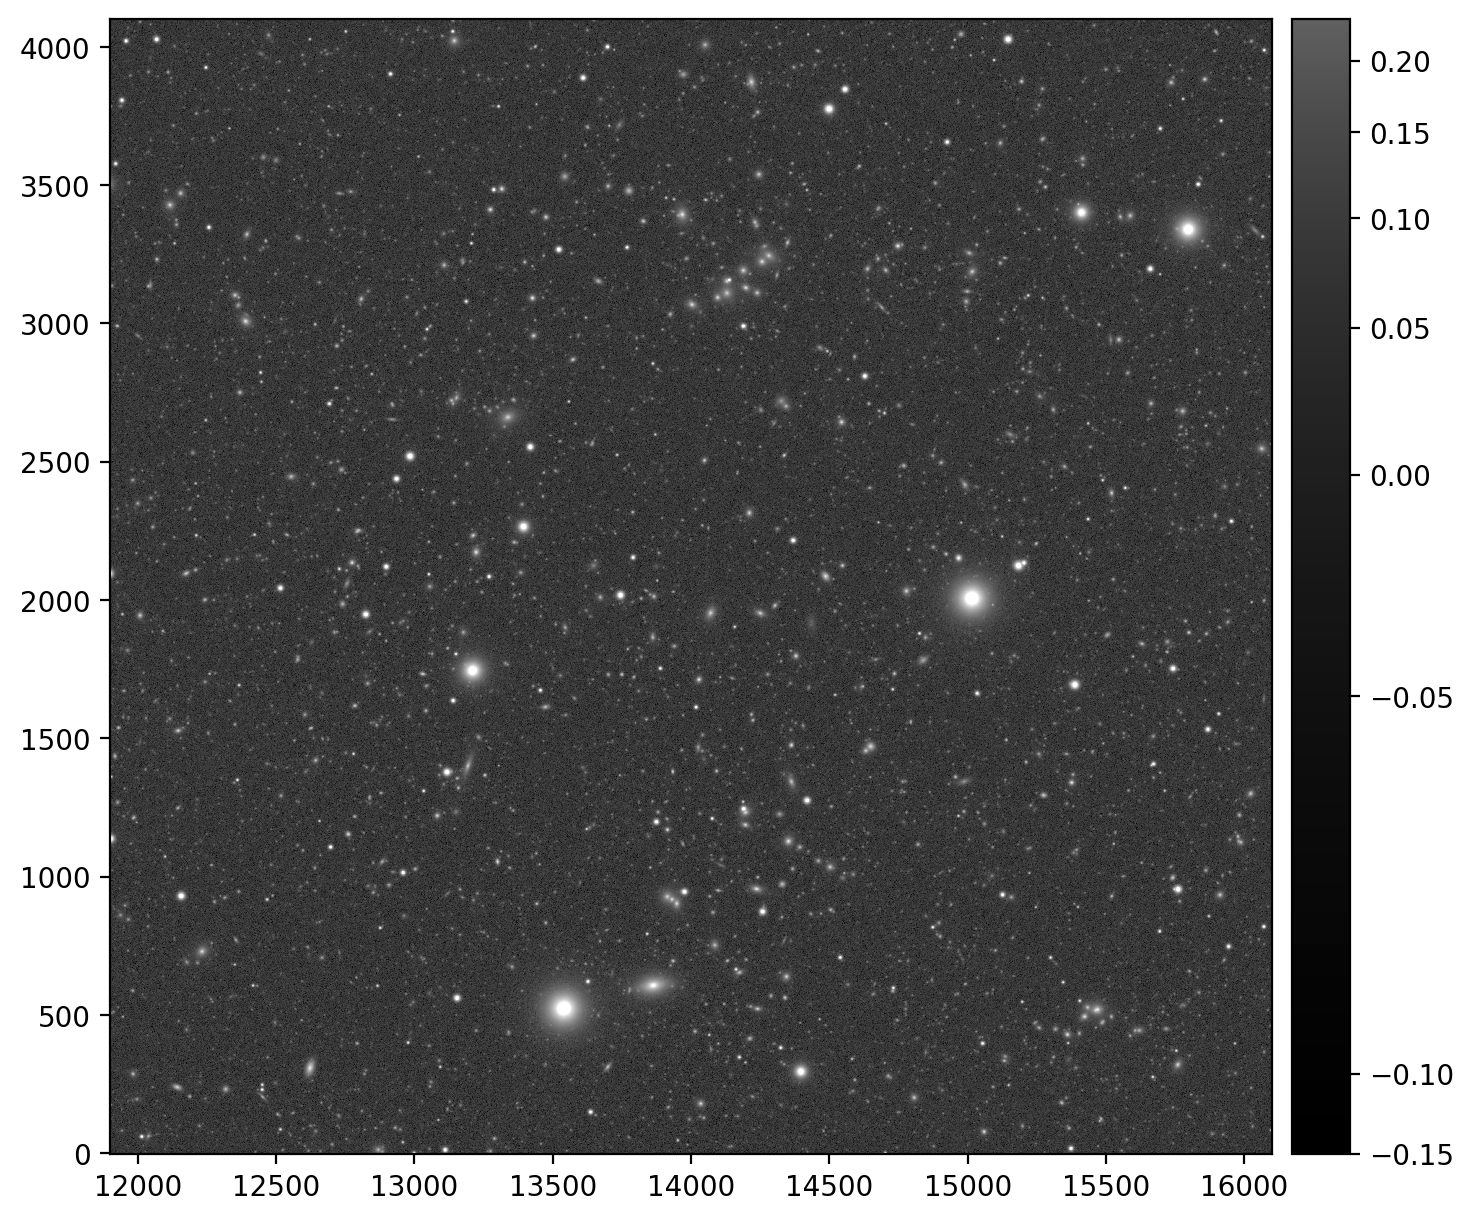

In [8]:
for deepCoaddDatum in deepCoaddData:
    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(deepCoaddDatum.image)
    plt.show()

In [9]:
for deepCoaddDatum in deepCoaddData:
    print(deepCoaddDatum.image.getBBox())

(minimum=(11900, 3900), maximum=(16099, 8099))
(minimum=(11900, 0), maximum=(16099, 4099))


You can see from the plot above (and the bbox printouts) that the two patches overlap and since our coordinate lies in the overlapping region we find two patches.

### Exercise 1c

Using the (tract, patch) with the lowest patch number, plot histograms of the seeing values of the images that were coadded in the r-band `deepCoadd` and `goodSeeingCoadd` for that (tract, patch).  Tutorial notebook 09a (Custom Coadd)will give you some ideas on how to get the `coaddInputs`.  The `coaddInputs.ccds` table will be helpful.

For each input `calexp`, you will need to retrieve the PSF and then use `psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()` to get the PSF width in sigma.  Convert these to FWHM in arcseconds for your plots.

In [10]:
from lsst.meas.algorithms.installGaussianPsf import FwhmPerSigma
from tqdm import tqdm

In [11]:
def get_pairs(dataType, tract, patch, band):
    coadd = butler.get(dataType, dataId={"tract": tract, "patch": patch, "band": band})
    coaddInputs = coadd.getInfo().getCoaddInputs()
    pairs = np.vstack((coaddInputs.ccds["visit"], coaddInputs.ccds["ccd"])).T
    del coadd, coaddInputs
    return pairs

In [12]:
tract, patch = (3831, 3)
pairs = get_pairs("deepCoadd", tract, patch, "r")
goodSeeingPairs = get_pairs("goodSeeingCoadd", tract, patch, "r")

In [13]:
# this is lazy N^2 but it works ¯\_(ツ)_/¯
good_indices = np.ones(len(goodSeeingPairs)).astype(int) * -1
for i, goodPair in enumerate(goodSeeingPairs):
    for j, pair in enumerate(pairs):
        if all(pair == goodPair):
            good_indices[i] = j
            break

In [14]:
def get_seeing(pair):
    visit_id, detector_id = pair
    psf = butler.get("calexp.psf", dataId={"visit": visit_id, "detector": detector_id})
    seeing_pixels_sigma = psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()
    
    # NOTE: to do this properly we should grab calexp.wcs and get the pixel scale
    # but I'm being lazy and it always pretty much 0.2 (:
    # wcs = butler.get("calexp.wcs", dataId={"visit": visit_id, "detector": detector_id})
    # pixel_to_arcseconds = wcs.getPixelScale().asArcseconds()
    pixel_to_arcseconds = 0.2
    
    del psf

    return seeing_pixels_sigma * FwhmPerSigma * pixel_to_arcseconds

In [15]:
from os.path import isfile

In [17]:
if not isfile("seeing_values.npy"):
    seeing_values = np.zeros(len(pairs))
    for i, pair in tqdm(enumerate(pairs)):
        seeing_values[i] = get_seeing(pair)
    
    # just in case kernel dies AGAIN (this machine hates me)
    np.save("seeing_values.npy", seeing_values)
else:
    seeing_values = np.load("seeing_values.npy")

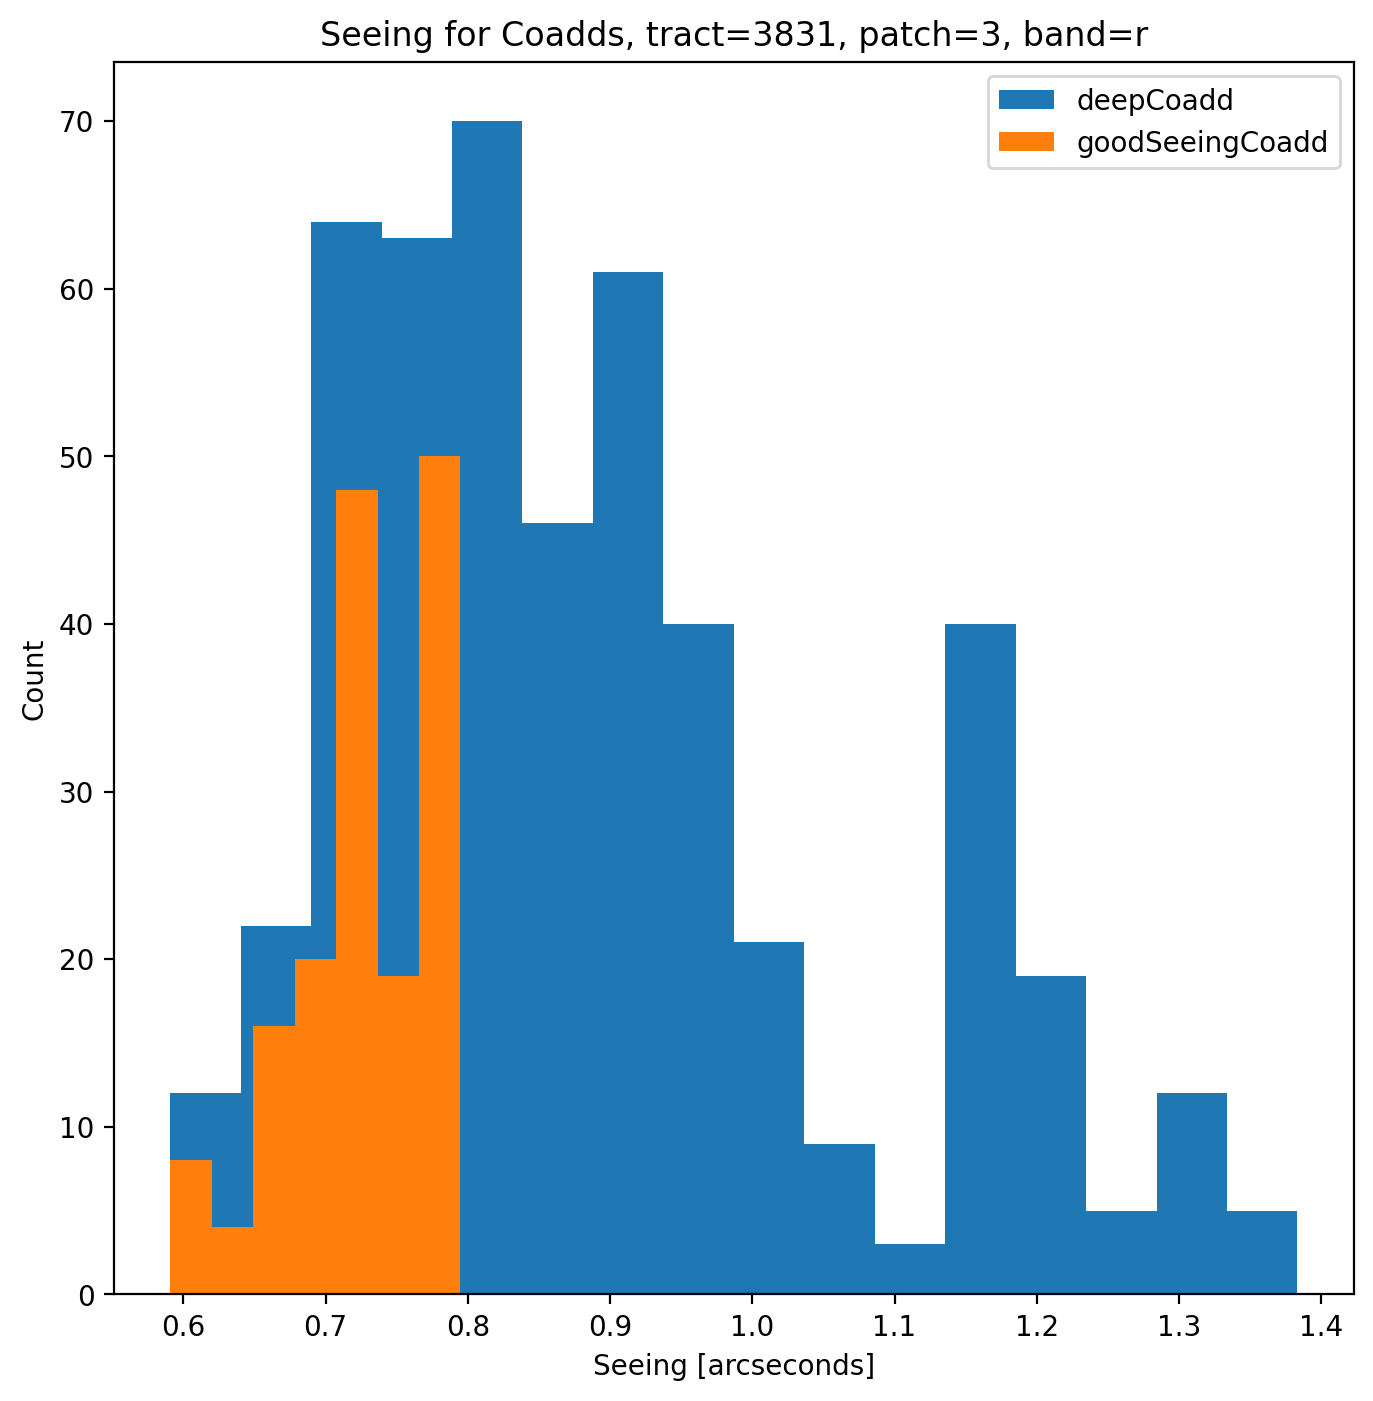

In [18]:
fig, ax = plt.subplots()

ax.hist(seeing_values, bins="fd", label="deepCoadd")
ax.hist(seeing_values[good_indices], bins="fd", label="goodSeeingCoadd")

ax.set_xlabel("Seeing [arcseconds]")
ax.set_ylabel("Count")

ax.legend()

ax.set_title(f"Seeing for Coadds, tract={tract}, patch={patch}, band=r")

plt.show()

So it looks like the good seeing coadds cut off around a seeing of 0.8 arcseconds ish.

## Exercise 2: DIY Good-seeing Coadd

Complete the `09a_Custom_Coadd` tutorial notebook, but rather than coadding all of the visits within a temporal window, instead coadd the three first three visits that have seeing values in the range included in the `goodSeeingCoadd` inputs.  Display the result and compare to the standard `deepCoadd` and `goodSeeingCoadd`.

Coadded template images are a necessary input to alert production.  What are the implications of this exercise for alert generation early in the LSST survey?  How many images were taken before three images had good enough seeing?  How long did the survey run before the images were acquired?

### First let's get all of the inputs/seeing values a la 1c

In [19]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
my_filter = 'i'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  4431 17


In [20]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

In [21]:
custom_pairs = get_pairs("deepCoadd", my_tract, my_patch, "i")
good_custom_pairs = get_pairs("goodSeeingCoadd", my_tract, my_patch, "i")

In [22]:
# this is lazy N^2 but it works ¯\_(ツ)_/¯
custom_good_indices = np.ones(len(good_custom_pairs)).astype(int) * -1
for i, goodPair in enumerate(good_custom_pairs):
    for j, pair in enumerate(custom_pairs):
        if all(pair == goodPair):
            custom_good_indices[i] = j
            break

In [23]:
if not isfile("custom_seeing.npy"):
    custom_seeing = np.zeros(len(custom_pairs))
    for i, pair in tqdm(enumerate(custom_pairs)):
        custom_seeing[i] = get_seeing(pair)
    
    # just in case kernel dies AGAIN (this machine hates me)
    np.save("custom_seeing.npy", custom_seeing)
else:
    custom_seeing = np.load("custom_seeing.npy")

In [24]:
seeing_lim = custom_seeing[custom_good_indices].max()

### Now we can see just the first three good seeing ones

In [26]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])
times = visitTable.loc[my_coadd_inputs.ccds["visit"]]["expMidptMJD"].values
order = np.argsort(times)

In [27]:
first_three = np.unique(my_coadd_inputs.ccds["visit"][order][custom_seeing[order] <= seeing_lim])[:3]

### And go through the rigamarole of putting them back together

In [28]:
import getpass

In [29]:
my_username = getpass.getuser()
my_collection_identifier = 'astr597_hw3'
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier

In [30]:
simpleButler = SimplePipelineExecutor.prep_butler('dp02', inputs=['2.2i/runs/DP0.2'], output=my_outputCollection)

In [31]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/tomwagg/astr597_hw3/20230120T222440Z', '2.2i/runs/DP0.2'))

In [32]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps

assembleCoaddPipeline = Pipeline.from_uri(my_uri)
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

In [33]:
my_visits_tupleString = "("+",".join(first_three.astype(str))+")"
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (174602,177422,192350) AND skymap = 'DC2'


In [34]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 647 ms, sys: 82.7 ms, total: 730 ms
Wall time: 15min 43s


In [35]:
%%time
quanta = spe.run()

CPU times: user 5min, sys: 13.2 s, total: 5min 13s
Wall time: 5min 33s


In [48]:
coadd_index = -1
quanta[coadd_index].outputs['deepCoadd']

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 4431, patch: 17})]

In [41]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

### How long do we need for these coadds?

In [75]:
days_to_deep = times.max() - times.min()

first_three_times = visitTable.loc[first_three]["expMidptMJD"].values
days_to_fast = first_three_times.max() - first_three_times.min()

### It's ~clobbering~ plotting time! 

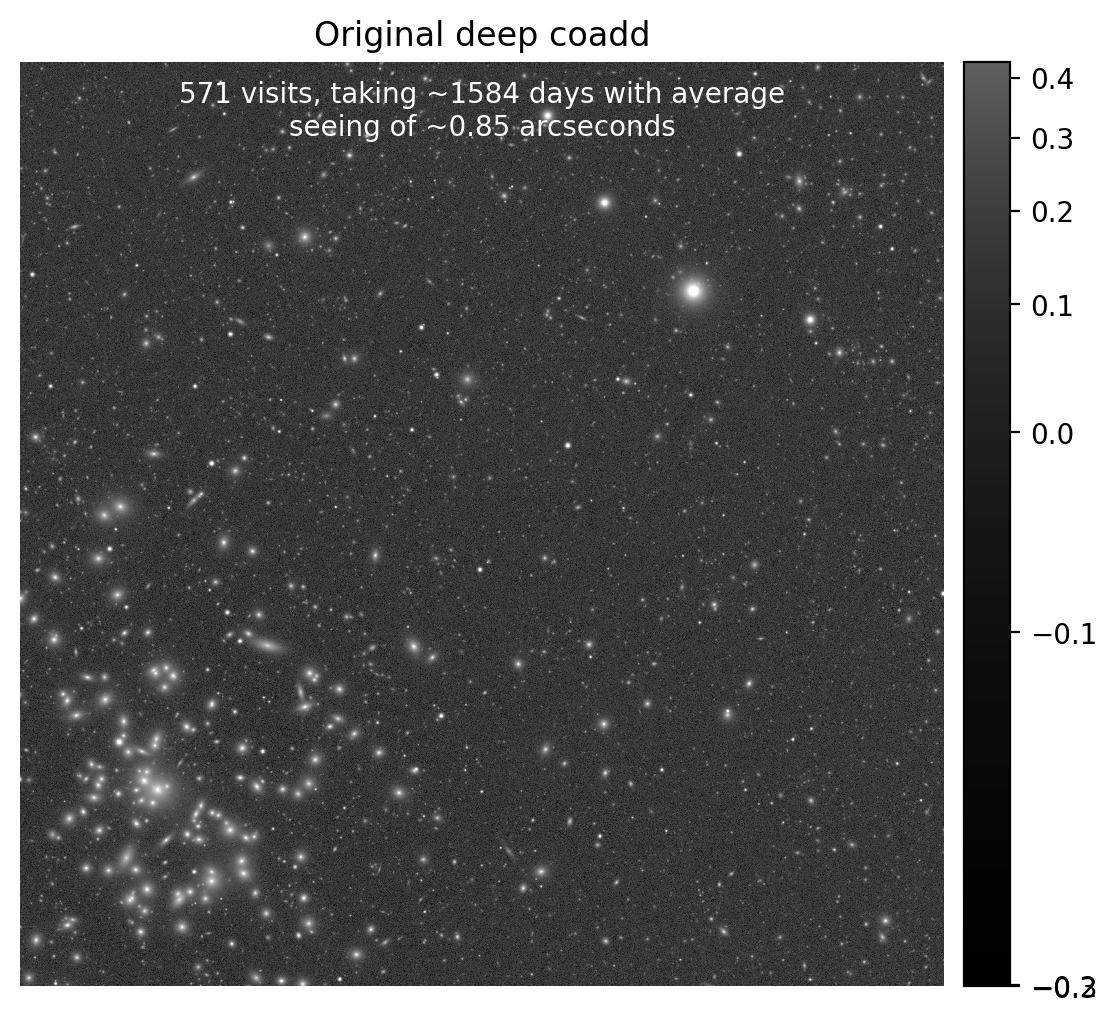

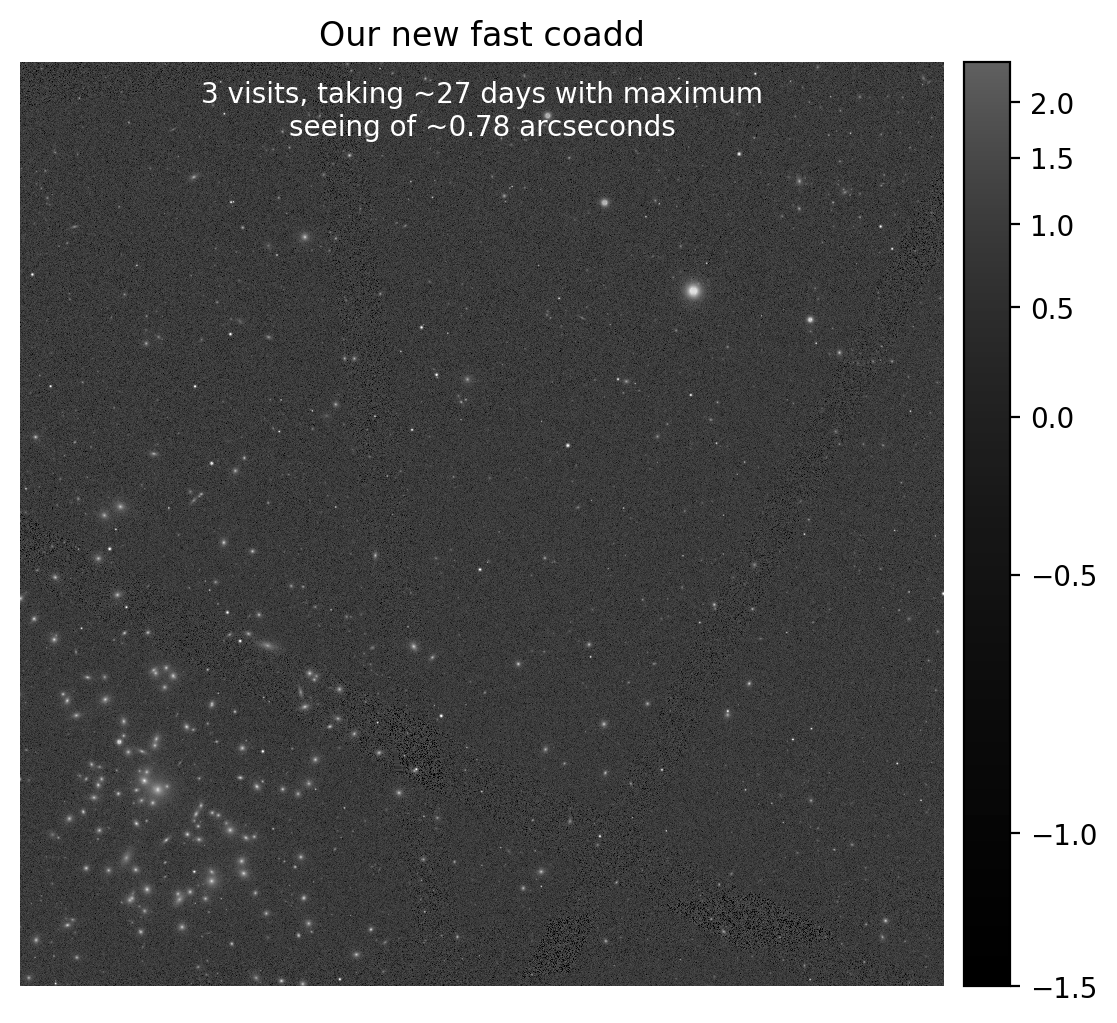

In [86]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('off')
plt.title("Original deep coadd")
plt.annotate(f"{len(my_coadd_inputs.ccds)} visits, taking ~{days_to_deep:1.0f} days with average\nseeing of ~{custom_seeing.mean():1.2} arcseconds",
             xy=(0.5, 0.98), xycoords="axes fraction", ha="center", va="top", color="white")
plt.show()

fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')
plt.title("Our new fast coadd")
plt.annotate(f"{3} visits, taking ~{days_to_fast:1.0f} days with maximum\nseeing of ~{seeing_lim:1.2} arcseconds",
             xy=(0.5, 0.98), xycoords="axes fraction", ha="center", va="top", color="white")
plt.show()

### So what did we learn?

Well this new "fast" coadd only takes 27 days to make...but it is clearly isn't nearly as good as the `deepCoadd`. This means that at the start of the survey alerts will have to rely on "shallower" coadds that might not achieve the same depth. For the brightest objects this seems like it should still work fine as they are visible on both images. But for fainter sources that need alerts we may struggle.

Also I suppose that generated alerts *before* those 27 days isn't going to be possible if this is a necessary input.